In [1]:
import numpy as np
import pandas as pd
import os, sys
import h5py
import scipy.stats, scipy.spatial.distance
import matplotlib.pyplot as plt

from matplotlib import cm

root = '/mnt/neurocube/local/serenceslab/maggie/shapeDim/'
feat_dir = os.path.join(root, 'Analysis', 'image_similarity', 'features')

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import grid_utils, plot_utils

#### load the GIST features

In [2]:
f = []
    
fn = os.path.join(feat_dir, 'gist', 'Images_grid3_gistdescriptors_4ori_4blocks.h5py')
print(fn)
with h5py.File(fn, 'r') as file:
    
    f = np.array(file['/features'])
    file.close()

f_gist = f

/mnt/neurocube/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/gist/Images_grid3_gistdescriptors_4ori_4blocks.h5py


#### load the SimCLR features

In [3]:
blocks_to_do = [2,6,12,15]
# blocks_to_do = [2]

f = []
for bb in blocks_to_do:
    
    fn = os.path.join(feat_dir, 'simclr', 'Images_grid3_simclr_block%d_pca.npy'%bb)
    print(fn)
    ftmp = np.load(fn)
    
    f.append(ftmp)
    
f = np.concatenate(f, axis=1)

fz = scipy.stats.zscore(f, axis=0)

f_simclr = f;

/mnt/neurocube/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/simclr/Images_grid3_simclr_block2_pca.npy
/mnt/neurocube/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/simclr/Images_grid3_simclr_block6_pca.npy
/mnt/neurocube/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/simclr/Images_grid3_simclr_block12_pca.npy
/mnt/neurocube/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/simclr/Images_grid3_simclr_block15_pca.npy


In [4]:
labs = pd.read_csv(os.path.join(feat_dir, 'Image_labels_grid3.csv'))

pts = np.array([labs['coord_axis1'], labs['coord_axis2']]).T

main_grid = grid_utils.get_main_grid()
gi = [np.argmin(np.sum((pts-g)**2, axis=1)) for g in main_grid]

f_gist_main = f_gist[gi,:]
f_simclr_main = f_simclr[gi,:]


In [6]:
gist_sep_eachaxis = np.zeros((3,))

for ai, axis in enumerate([1,2,3]):

    l = np.array(labs['labels_task%d'%axis])[gi].astype(int)

    group1 = f_gist_main[l==1,:]
    group2 = f_gist_main[l==2,:]
    
    # get all the within-category distances
    within1 = scipy.spatial.distance.pdist(group1, metric='euclidean')
    within2 = scipy.spatial.distance.pdist(group2, metric='euclidean')
    
    # get all the across-category distances
    cat = np.concatenate([group1, group2], axis=0)
    between = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(cat))
    between = between[0:8,8:]
    between = between.ravel()
    
    b = np.mean(between)
    w = np.mean(np.concatenate([within1, within2], axis=0))
    sep =  (b-w) / (b+w)
    
    gist_sep_eachaxis[ai] = sep
    
gist_sep_eachaxis

array([0.14044268, 0.18939077, 0.01392477])

In [7]:
simclr_sep_eachaxis = np.zeros((3,))

for ai, axis in enumerate([1,2,3]):

    l = np.array(labs['labels_task%d'%axis])[gi].astype(int)

    group1 = f_simclr_main[l==1,:]
    group2 = f_simclr_main[l==2,:]
    
    # get all the within-category distances
    within1 = scipy.spatial.distance.pdist(group1, metric='euclidean')
    within2 = scipy.spatial.distance.pdist(group2, metric='euclidean')
    
    # get all the across-category distances
    cat = np.concatenate([group1, group2], axis=0)
    between = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(cat))
    between = between[0:8,8:]
    between = between.ravel()
    
    b = np.mean(between)
    w = np.mean(np.concatenate([within1, within2], axis=0))
    sep =  (b-w) / (b+w)
    
    simclr_sep_eachaxis[ai] = sep
    
simclr_sep_eachaxis

array([0.07823882, 0.13236554, 0.01961921])

In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

In [9]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])


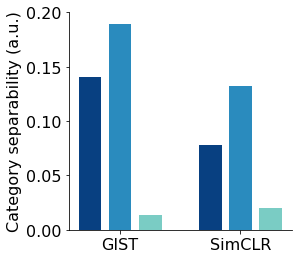

In [10]:
from code_utils import plot_utils
from matplotlib import cm

vals = np.array([gist_sep_eachaxis, simclr_sep_eachaxis]).T

colors=cm.Purples(np.linspace(0,1,4))[[1,2]]

xjitter = np.linspace(-0.25, 0.25, 3)
bw = np.diff(xjitter)[0]/4 * 3

plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)
# for bb in range(3):
#     plt.plot(bb+np.array(xjitter), vals[bb,:], '-', color=[0.8, 0.8, 0.8])
#     for xi in range(2):
#         plt.plot(bb+xjitter[xi], vals[bb,xi], 'o', color=colors[xi,:])
    
    
# 
for xi in range(2):
    plt.bar(xi+np.array(xjitter), vals[:,xi], width = bw, color=task_colors[0:3,:])
    
plt.xticks(np.arange(2), ['GIST', 'SimCLR'], rotation=0)
    
plt.ylabel('Category separability (a.u.)')
plt.ylim([0, 0.20])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

figname = os.path.join(figfolder, 'image_category_sep.pdf')
plt.savefig(figname)

In [11]:
from sklearn import decomposition
pca = decomposition.PCA(n_components = 100, copy=True)
scores = pca.fit_transform(f_gist)    
scores_main = scores[gi,:]

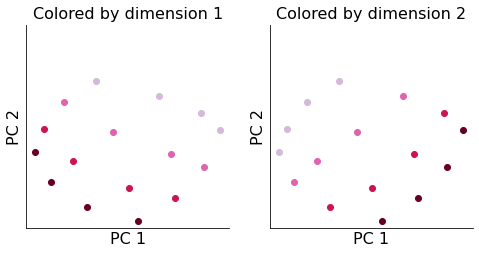

In [12]:
# viridis = cm.get_cmap('viridis')

grid = np.unique(main_grid[:,0])

plt.figure(figsize=(8,4))

ax = plt.subplot(1,2,1)

cols2plot = cm.PuRd(np.linspace(0,1,len(grid)+1))[1:]

for ii in range(len(grid)):
    inds2plot = np.where(main_grid[:,0]==grid[ii])[0]
    plt.plot(scores_main[inds2plot,0],scores_main[inds2plot,1],'o',color=cols2plot[ii,:])

plt.axis('square');
plt.xticks([]);
plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Colored by dimension 1');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = plt.subplot(1,2,2)

for ii in range(len(grid)):
    inds2plot = np.where(main_grid[:,1]==grid[ii])[0]
    plt.plot(scores_main[inds2plot,0],scores_main[inds2plot,1],'o',color=cols2plot[ii,:])

plt.axis('square');
plt.xticks([]);
plt.yticks([]);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
plt.title('Colored by dimension 2');

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

figname = os.path.join(figfolder, 'image_gist_pca.pdf')
plt.savefig(figname)

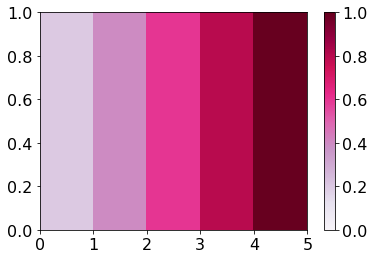

In [14]:
plt.figure()
plt.pcolormesh(np.reshape(np.linspace(0,1,6)[1:], [1,5]), cmap='PuRd', vmin=0, vmax=1)
plt.colorbar()
figname = os.path.join(figfolder, 'image_gist_pca_colorbar.pdf')
plt.savefig(figname)